In [1]:
#biblioteca
import numpy as np
import matplotlib.pyplot as plt
from numba import jit,njit
import pandas as pd
import tensorflow as tf
from tqdm import tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Artigo reproduzido
https://www.nature.com/articles/nphys4035.pdf

# Ising model

In [3]:
@njit(parallel=True,fastmath=True,cache=True)
def ising_model_optimized(N, steps, J, H, T):
    """ Simulate the Ising model using the Metropolis algorithm with optimizations. """
    lattice = np.random.choice(np.array([-1, 1]), size=(N, N))

    # Precompute exponential values for possible delta_E values
    max_delta_E = 2 * (4 * J + H)  # max change in energy when flipping a spin
    min_delta_E = -max_delta_E
    exp_table = np.exp(np.arange(min_delta_E, max_delta_E + 1, 2) / -T)

    for step in range(steps):
      # Metropolis algorithm with optimizations
      for _ in range(N*N):
        i, j = np.random.randint(0, N),np.random.randint(0, N)
        S = lattice[i, j]
        neighbors = lattice[(i+1)%N, j] + lattice[i, (j+1)%N] + lattice[(i-1)%N, j] + lattice[i, (j-1)%N]#condição de contorno ciclica
        dE = 2 * S * (J * neighbors + H)
        random_values = np.random.rand()
        if dE < 0 or random_values < exp_table[int((dE - min_delta_E) / 2)]:
            lattice[i, j] *= -1  # Flip the spin
    return lattice

# Parameters
steps = 1000  # Number of steps in the Monte Carlo simulation
J = 1  # Exchange interaction
H = 0  # External magnetic field
T = 2.5  # Temperature


# Run the simulation
final_lattice = ising_model_optimized(30, steps, J, H, T)


# Salvando os dados no pandas

In [4]:
# Parameters
steps = 1000  # Number of steps in the Monte Carlo simulation
J = 1  # Exchange interaction
H = 0  # External magnetic field
matrizes=np.empty((1001,2),dtype=object)
#parametros
L=50
for i,T in enumerate(tqdm(np.linspace(1,3.5,1001))):
  #ising model
  matrizes[i]=([ising_model_optimized(L, steps, J, H, T).flatten(),T])

df=pd.DataFrame(matrizes)
#df[2]=np.where(df[1]>=2.26,1,0)

100%|██████████| 1001/1001 [03:53<00:00,  4.29it/s]


# Separando os dados para treino e teste

In [5]:
from sklearn.model_selection import train_test_split

#colocando os dados em uma rede
X=np.empty((df[0].shape[0],L*L),dtype=np.float32)
for i,array in enumerate(df[0]):
  X[i]=array
#categorizando os dados
Y=np.empty((df.shape[0],2),dtype=np.float32)
for i,T in enumerate(df[1]):
  Y[i]=[0,1] if T>2.26 else [1,0]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,shuffle=True)

# Construido o Modelo

In [6]:
def build_model(input_shape, num_classes):

    # Cria um modelo sequencial
    model = tf.keras.Sequential([
        # Camada de entrada, especifica o formato de entrada
        tf.keras.layers.InputLayer(input_shape=input_shape),
        # Primeira camada oculta com 128 neurônios e ativação sigmoid
        tf.keras.layers.Dense(100, activation='sigmoid'),
        # Camada de saída com função de ativação softmax para classificação multiclasse
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])
    # Compila o modelo
    model.compile(
        optimizer='Adam',  # Otimizador
        loss='BinaryCrossentropy',  # Função de perda para classificação de múltiplas classes
        metrics=['accuracy']  # Métrica de avaliação
    )
    return model

def evaluate_model(model, test_data, test_labels):
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=1)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    return test_loss, test_accuracy
# Definição dos parâmetros do modelo
input_shape = (L*L,)  # Imagens LxL achatadas
num_classes = 2  # Número de classes, por exemplo, para o MNIST

# Criação do modelo
model = build_model(input_shape, num_classes)
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │         250,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,302 (977.74 KB)

 Trainable params: 250,302 (977.74 KB)

 Non-trainable params: 0 (0.00 B)

None


#Rodando o modelo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 100)                 │         250,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             202 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,302 (977.74 KB)

 Trainable params: 250,302 (977.74 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
21/21 - 1s - 66ms/step - accuracy: 0.4701 - loss: 0.7374
Epoch 2/10
21/21 - 0s - 7ms/step - accuracy: 0.8687 - loss: 0.5458
Epoch 3/10
21/21 - 0s - 8ms/step - accuracy: 0.9403 - loss: 0.4418
Epoch 4/10
21/21 - 0s - 14ms/step - accuracy: 0.9687 - loss: 0.3566
Epoch 5/10
21/21 - 0s - 7ms/step - accuracy: 0.9836 - loss: 0.2835
Epoch 6/10
21/21 - 0s - 15ms/step - accuracy: 0.9866 - loss: 0.2272
Epoch 7/10
21/21 - 0s - 8ms/step - accuracy: 0.9881 - loss: 0.1835
Epoch 8/10
21/21 - 0s - 15ms/step - accuracy: 0.9896 - loss: 0.1453
Epoch 9/10
21/21 - 0s - 13ms/step - accuracy: 0.9970 - loss: 0.1154
Epoch 10/10
21/21 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0931
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5794 - loss: 1.3995  
Test Loss: 1.2866740226745605
Test Accuracy: 0.5921450257301331


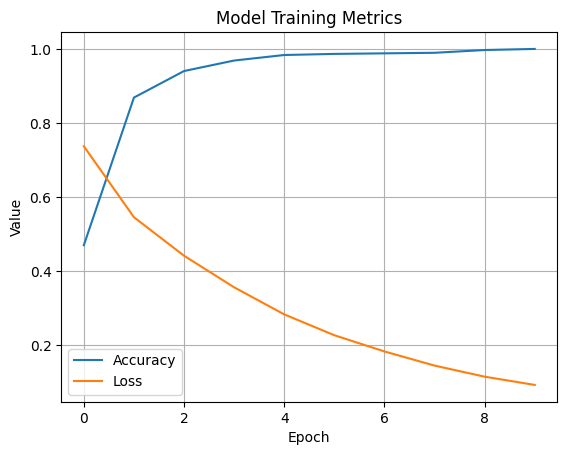

In [7]:
# Dummy data creation for demonstration
num_classes = 2
input_shape = (L * L,)
num_samples = 1000


# Build the model
model = build_model(input_shape, num_classes)
print(model.summary())

# Train the model
history = model.fit(X_train.astype('float32'),Y_train.astype('int'),epochs=10,verbose=2)
evaluate_model(model, X_test,Y_test)
#model.evaluate(X_test,Y_test,verbose=2)

# Optionally plot the training results
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()